In [232]:
import numpy as np #ref
import os
from os import path as op
import string
import re
from subprocess import Popen
import xarray as xr #ref
import metpy #ref
import matplotlib.pyplot as plt #ref
import cartopy.crs as ccrs #ref
import cartopy.feature as cfeature
from pyresample import image, geometry #ref
import seaborn as sns #ref
import netCDF4
sns.set(style="darkgrid")
%matplotlib inline

#sys.path.append('')

In [319]:
def create_nc_Numpy(ncFile, pathIn, pathOut):
    myFile = xr.open_dataset(op.join(pathIn,ncFile))
    dat = myFile.metpy.parse_cf('Rad')
    geos = dat.metpy.cartopy_crs

    cartopy_extent_goes = geos.x_limits + geos.y_limits
    rad = dat.data
    
    def normIm(im,gamma=1.0,reverse=False):
        nim = ((im-np.nanmin(im))*(np.nanmax(im)-np.nanmin(im))**(-1))
        if reverse:#want clouds to be white
            nim = (1.0-nim**(gamma))
        return nim
    
    def goes_2_roi(loaded_goes, 
               target_extent,
               target_rows,#actual length or base
               target_cols,#actual width or height
               cartopy_target_proj,
               data_key='Rad',
               radius_of_influence=50000):
        """Function that goes from loaded GOES data to data resampled in a projection for an extent"""
        dat = loaded_goes.metpy.parse_cf('Rad')
        geos_crs = dat.metpy.cartopy_crs
        cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
        pyresample_source_extent = (cartopy_source_extent[0],
                                    cartopy_source_extent[2],
                                    cartopy_source_extent[1],
                                    cartopy_source_extent[3])
        rad = dat.data
        source_area = geometry.AreaDefinition('GOES-1X', 'Full Disk','GOES-1X', 
                                              geos_crs.proj4_params,
                                              rad.shape[1], rad.shape[0],
                                              pyresample_source_extent)
        area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                            cartopy_target_proj.proj4_params,
                                            target_rows, target_cols,
                                            target_extent)
        geos_con_nn = image.ImageContainerNearest(rad, 
                                                source_area, 
                                                radius_of_influence=radius_of_influence)

        # Here we are using pyresample for the remapping
        area_proj_con_nn = geos_con_nn.resample(area_target_def)
        return area_proj_con_nn.image_data
        
    def cartopy_pyresample_toggle_extent(input_extent):
        return np.array(input_extent)[np.array([0,2,1,3])]

    def trasform_cartopy_extent(source_extent,source_proj, target_proj):
        target_extent = target_proj.transform_points(source_proj, 
                                                     np.array(source_extent[:2]),
                                                     np.array(source_extent[2:])).ravel()
        # target_extent in 3D, must be in 2D
        return cartopy_pyresample_toggle_extent(np.array(target_extent)[np.array([0,1,3,4])])
    pc = ccrs.PlateCarree()
    mc = ccrs.Mercator()

    # Convert extent from pc to mc (both cylindrical projections)
    #extent_pc = [-124.40975000,-114.13138889, 45.00305556, 32.53472222]
    extent_pc = [-130, -105, 50.00305556, 25.53472222]
    
    target_extent_mc_cartopy = trasform_cartopy_extent(extent_pc, pc, mc)
    target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)
    
    roi_rads = goes_2_roi(myFile,
               target_extent_mc_pyresample,
               400,1000,
               mc)
    ####
    full_filename = op.join(pathOut,ncFile[:-3])
    np.save(full_filename,roi_rads)
    myFile.close()
    return

In [320]:
pathIn = 'folder/'
ncFile = 'OR_ABI-L1b-RadC-M6C03_G17_s20201861001178_e20201861003551_c20201861003592.nc'
myFile = xr.open_dataset(op.join(pathIn,ncFile))
#myFile.info
dat = myFile.metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs

cartopy_extent_goes = geos.x_limits + geos.y_limits

# goes_params = geos.proj4_params
# rad = dat.data

FileNotFoundError: [Errno 2] No such file or directory: b'/sharedData2/nshakoor/fires_research/Fires/Downloader/folder/OR_ABI-L1b-RadC-M6C03_G17_s20201861001178_e20201861003551_c20201861003592.nc'

In [289]:
geos.x_limits

(-5434182.0342756845, 5434182.0342756845)

In [284]:
create_nc_Numpy('OR_ABI-L1b-RadC-M3C03_G17_s20183221802189_e20183221804562_c20183221804595.nc', 'folder/', 'folder/npy/')

/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(


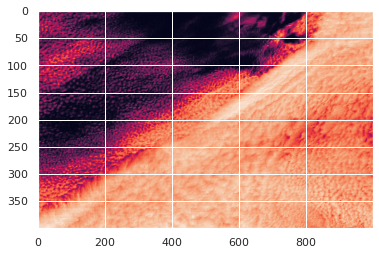

In [321]:
img_array = np.load("folder/npy/OR_ABI-L1b-RadC-M3C03_G17_s20183221802189_e20183221804562_c20183221804595.npy")
plt.imshow(img_array, aspect='auto')
plt.show()

In [225]:
type(img_array)

numpy.ndarray

In [226]:
img_array.max(), img_array.min(), 

(131.56602, 1.9081202)

In [227]:
x = np.log(img_array)

In [228]:
x.max(), x.min()

(4.879509, 0.6461185)

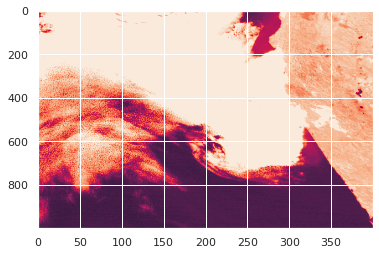

In [229]:
plt.imshow(x, aspect='auto', vmax=4)
plt.show()

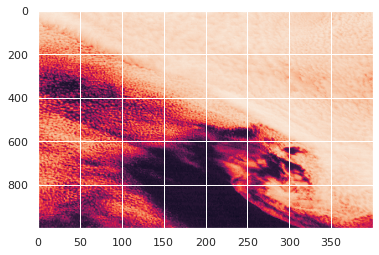

In [215]:
plt.imshow(x, aspect='auto')
plt.show()

In [314]:
def create_nc_Numpy(ncFile, pathIn, pathOut):
    myFile = xr.open_dataset(op.join(pathIn,ncFile))
    dat = myFile.metpy.parse_cf('Rad')
    geos = dat.metpy.cartopy_crs

    cartopy_extent_goes = geos.x_limits + geos.y_limits
    goes_params = geos.proj4_params
    rad = dat.data
    
    def normIm(im,gamma=1.0,reverse=False):
        nim = ((im-np.nanmin(im))*(np.nanmax(im)-np.nanmin(im))**(-1))
        if reverse:#want clouds to be white
            nim = (1.0-nim**(gamma))
        return nim
    
    def goes_2_roi(loaded_goes, 
               target_extent,
               target_rows,#actual length or base
               target_cols,#actual width or height
               cartopy_target_proj,
               data_key='Rad',
               radius_of_influence=50000):
        """Function that goes from loaded GOES data to data resampled in a projection for an extent"""
        dat = loaded_goes.metpy.parse_cf('Rad')
        geos_crs = dat.metpy.cartopy_crs
        cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
        pyresample_source_extent = (cartopy_source_extent[0],
                                    cartopy_source_extent[2],
                                    cartopy_source_extent[1],
                                    cartopy_source_extent[3])
        rad = dat.data
        source_area = geometry.AreaDefinition('GOES-1X', 'Full Disk','GOES-1X', 
                                              geos_crs.proj4_params,
                                              rad.shape[1], rad.shape[0],
                                              pyresample_source_extent)
        area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                            cartopy_target_proj.proj4_params,
                                            target_rows, target_cols,
                                            target_extent)
        geos_con_nn = image.ImageContainerNearest(rad, 
                                                source_area, 
                                                radius_of_influence=radius_of_influence)

        # Here we are using pyresample for the remapping
        area_proj_con_nn = geos_con_nn.resample(area_target_def)
        return area_proj_con_nn.image_data
        
    def cartopy_pyresample_toggle_extent(input_extent):
        return np.array(input_extent)[np.array([0,2,1,3])]

    def trasform_cartopy_extent(source_extent,source_proj, target_proj):
        target_extent = target_proj.transform_points(source_proj, 
                                                     np.array(source_extent[:2]),
                                                     np.array(source_extent[2:])).ravel()
        # target_extent in 3D, must be in 2D
        return cartopy_pyresample_toggle_extent(np.array(target_extent)[np.array([0,1,3,4])])
    pc = ccrs.PlateCarree()
    mc = ccrs.Mercator()

    # Convert extent from pc to mc (both cylindrical projections)
    #extent_pc = [-124.40975000,-114.13138889, 45.00305556, 32.53472222]
    extent_pc = [-130, -105, 50.00305556, 25.53472222]
#     rows = extent_pc[3] - extent_pc[2]
#     cols = extent_pc[1] - extent_pc[0]
    
    target_extent_mc_cartopy = trasform_cartopy_extent(extent_pc, pc, mc)
    target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)
    
    roi_rads = goes_2_roi(myFile,
               target_extent_mc_pyresample,
               1000, 400,
               mc)
    ####
    full_filename = op.join(pathOut,ncFile[:-3])
    np.save(full_filename,roi_rads)
    myFile.close()
    return

In [315]:
create_nc_Numpy('OR_ABI-L1b-RadC-M3C03_G17_s20183221802189_e20183221804562_c20183221804595.nc', 'folder/', 'folder/npy/')

/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(


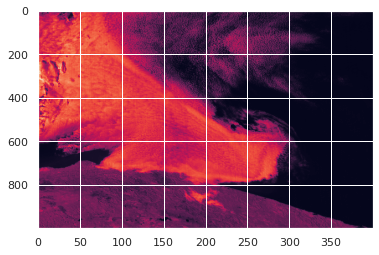

In [316]:
img_array = np.load("folder/npy/OR_ABI-L1b-RadC-M3C03_G17_s20183221802189_e20183221804562_c20183221804595.npy")
plt.imshow(img_array, aspect='auto')
plt.show()

/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


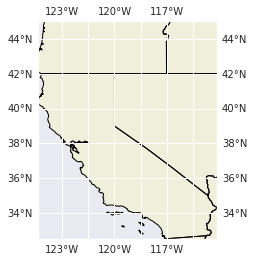

In [299]:
ax0 = plt.axes(projection=ccrs.PlateCarree())
ax0.set_extent([-124.40975000,-114.13138889, 45.00305556, 32.53472222], crs=ccrs.PlateCarree())

ax0.add_feature(ccrs.cartopy.feature.LAND)
#ax0.add_feature(cfeature.LAND.with_scale('110m'))
ax0.add_feature(ccrs.cartopy.feature.STATES)
ax0.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.show()

In [ ]:
# dat = myFile.metpy.parse_cf('Rad')
# geos = dat.metpy.cartopy_crs

pc = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 1, 1, projection=pc)

ax1.set_extent([-124.40975000,-114.13138889, 45.00305556, 32.53472222], crs=pc)
ax1.imshow(dat, origin='upper',
           #extent=(-124.40975000,-114.13138889, 45.00305556, 32.53472222),
           transform=geos,
           interpolation='none')
ax1.add_feature(ccrs.cartopy.feature.STATES)

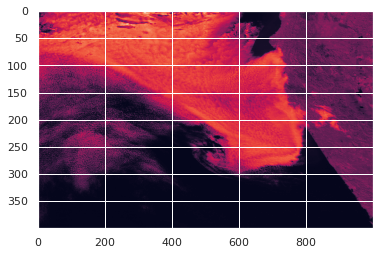

In [313]:
img_array = np.load("folder/npy/OR_ABI-L1b-RadC-M3C03_G17_s20183221802189_e20183221804562_c20183221804595.npy")
plt.imshow(img_array, aspect='auto')
plt.show()